In [91]:
import os

os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test")

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from RadEyeG20 import * 
import h5py
import pyvisa
import time
from scipy.signal import savgol_filter
import scipy.signal as signal
from scipy import interpolate
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.ticker import MaxNLocator
from scipy.optimize import least_squares
import winsound
import nidaqmx
import pandas as pd

# If the imports don't work, press F1, find "Developer: Reload Window"

factor = 2
SMALL_SIZE = factor*8
MEDIUM_SIZE = factor*10
BIGGER_SIZE = factor*12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title4

#rm = pyvisa.ResourceManager()
#rm.list_resources()


In [92]:
import os

os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test\\4-1-2025_test")

#### Load NI USB6002 for voltage ramp and data reading

In [93]:
device_name = "dev1"
DAQ_read_channels = ["ai0","ai1","ai2", "ai3"]
DAQ_write_channel = "ao0"
DAQ_timeout = 5000

#### Load Radeye for X ray reading

In [94]:
# Example usage
time_offset = 1
com_port =  'ASRL4::INSTR'  # Replace with detected COM port
radeye = RadEyeG20(time_offset , com_port)

In [ ]:
radeye.instr.timeout = 2_000
radeye.instr.clear()
tstart = time.time()
for _ in range(10):
    print(radeye.ReadDoseRate() / 1_000)
print((time.time() - tstart) / 10)

0.07
0.07
0.07
0.07
0.07
0.07
0.07
0.07
0.07
0.07
0.9850495815277099


### Data collection functions

In [ ]:
# RAMP TO VOLTAGE 


def ramp_to(start_v, end_v, total_ramp_time=60, v_step=0.001):
    """
    Ramps the voltage on the DAQ output from start_v to end_v over total_ramp_time, using steps of v_step.
    
    Parameters:
        start_v (float): Starting voltage, must be between 0 and 10.1.
        end_v (float): Ending voltage, must be between 0 and 10.1.
        total_ramp_time (float): Total time for the voltage ramp (default is 60 seconds).
        v_step (float): Voltage step (default is 0.001 volts).
    """
    # Check if input voltages are within the valid range
    if not (0 <= start_v <= 10.1) or not (0 <= end_v <= 10.1):
        print("Error: Voltage must be between 0 and 10.1 volts.")
        return
    
    # Calculate the total number of steps and the time interval (dt) between steps
    voltage_range = abs(end_v - start_v)
    num_steps = int(voltage_range / v_step)  # Number of voltage steps
    dt = total_ramp_time / num_steps  # Time between each voltage step
    print(dt)
    
    # Set the initial voltage to start_v
    current_voltage = start_v

    try:
        with nidaqmx.Task() as task:
            # Configure the AO0 channel on device "dev1"
            task.ao_channels.add_ao_voltage_chan("dev1/ao0", min_val=0.0, max_val=10.1)
            
            # Set the initial voltage to start_v
            task.write(current_voltage)
            print(f"Starting ramp from {start_v}V to {end_v}V with step {v_step}V.")
            
            # Determine the direction of the ramp (up or down)
            step_direction = 1 if end_v > start_v else -1
            
            for _ in range(num_steps):
                # Update the current voltage in the direction of the ramp
                current_voltage += step_direction * v_step
                
                # Output the new voltage to the DAQ
                task.write(current_voltage)
                print(f"current voltage: {current_voltage}V.")
                
                # Wait for the calculated time step
                time.sleep(dt)
                
                # Placeholder for additional error checking or exception handling
                # You can add custom error handling code here
                pass

    except Exception as e:
        # If any exception occurs, handle it here
        print(f"An exception occurred: {str(e)}. Exiting ramp.")
        return

    print(f"Successfully ramped from {start_v}V to {current_voltage}V.")


def ramp_multi(min_v, max_v, tot_measure_time, total_rampup_time=60,total_rampdown_time=60, v_step=0.01):
    
    for i in range(tot_measure_time):

        ramp_and_record(min_v,max_v, i, total_rampup_time, v_step)

        record(300,i,"rec_at_10_")

        ramp_and_record(max_v,min_v, i, total_rampdown_time, v_step)

        record(60,i,"rec_at_0_")

    


In [ ]:
def record_live_stream(measure_time, record_duration=30, filename="record_live_stream", radeye=None):

    sample_interval = 0.1
    sample_rate = 1 / sample_interval
    num_samples = int(record_duration * sample_rate)

    xray_connected = radeye is not None and radeye.instr is not False

    full_file_name = f"{filename}_{record_duration}s_{measure_time}.hdf"
    if os.path.exists(full_file_name):
        os.remove(full_file_name)

    xray_times = []
    xray_doses = []

    if xray_connected:
        plt.ioff()
        fig, ax = plt.subplots()
        line, = ax.plot([], [], marker='o')
        ax.set_title("Live X-ray Dose Rate (µSv/h)")
        ax.set_xlabel("Elapsed Time (s)")
        ax.set_ylabel("Dose Rate (µSv/h)")
        ax.grid(True)

    with h5py.File(full_file_name, "w") as h5f:
        # DAQ dataset
        daq_columns = ["Elapsed_Time"] + DAQ_read_channels
        dset_daq = h5f.create_dataset(
            "daq_data", shape=(0, len(daq_columns)),
            maxshape=(None, len(daq_columns)), dtype='float64', chunks=True
        )
        dset_daq.attrs["record_duration"] = record_duration
        dset_daq.attrs["sample_interval"] = sample_interval
        dset_daq.attrs["columns"] = daq_columns

        # X-ray dataset
        if xray_connected:
            xray_columns = ["Elapsed_Time", "Xray_Timestamp", "Xray_DoseRate_uSv_h"]
            dset_xray = h5f.create_dataset(
                "xray_data", shape=(0, len(xray_columns)),
                maxshape=(None, len(xray_columns)), dtype='float64', chunks=True
            )
            dset_xray.attrs["sample_interval"] = 1.0
            dset_xray.attrs["columns"] = xray_columns

        with nidaqmx.Task() as read_task, nidaqmx.Task() as write_task:
            for ch in DAQ_read_channels:
                read_task.ai_channels.add_ai_voltage_chan(f"{device_name}/{ch}")
            write_task.ao_channels.add_ao_voltage_chan(f"{device_name}/{DAQ_write_channel}", min_val=0.0, max_val=10.1)

            read_task.start()
            start_time = time.time()
            last_xray_time = 0

            for i in range(num_samples):
                raw_daq = read_task.read(number_of_samples_per_channel=10)
                daq_values = [v[0] for v in raw_daq]
                elapsed = time.time() - start_time

                # Save DAQ data
                row_data = np.array([[elapsed, *daq_values]])
                dset_daq.resize((dset_daq.shape[0] + 1, dset_daq.shape[1]))
                dset_daq[-1:] = row_data

                # X-ray data sampling
                if xray_connected and int(elapsed) > last_xray_time:
                    last_xray_time = int(elapsed)
                    try:
                        xray_time, xray_dose_nSv = radeye.ReadValue()
                        xray_dose_uSv = xray_dose_nSv / 1000.0
                    except Exception:
                        xray_time, xray_dose_uSv = -1, -1

                    # Emergency trigger
                    if xray_dose_uSv > 10:
                        write_task.write(0.0)
                        print(f"Emergency stop: dose rate exceeded 10 µSv/h at {elapsed:.1f}s.")
                        break

                    xray_row = np.array([[elapsed, xray_time, xray_dose_uSv]])
                    dset_xray.resize((dset_xray.shape[0] + 1, dset_xray.shape[1]))
                    dset_xray[-1:] = xray_row

                    # Update live plot
                    xray_times.append(elapsed)
                    xray_doses.append(xray_dose_uSv)
                    line.set_data(xray_times, xray_doses)
                    ax.relim()
                    ax.autoscale_view()
                    clear_output(wait=True)
                    display(fig)
                    plt.pause(0.001)

                time.sleep(sample_interval)

    print(f"Recording complete. Data saved to {full_file_name}")


In [90]:
def ramp_and_record_live_stream(start_v, end_v, measure_time, total_ramp_time=60, v_step=0.001,
                                filename="ramp_and_record_live_stream", radeye=None):

    if not (0 <= start_v <= 10.1) or not (0 <= end_v <= 10.1):
        return

    voltage_range = abs(end_v - start_v)
    num_steps = int(np.ceil(voltage_range / v_step))
    dt = total_ramp_time / num_steps
    step_direction = 1 if end_v > start_v else -1
    current_voltage = start_v

    xray_connected = radeye is not None and radeye.instr is not False

    full_file_name = f"{filename}_{start_v:.3f}V_to_{end_v:.3f}V_step_{v_step}V_in_{total_ramp_time}s_{measure_time}.hdf"
    if os.path.exists(full_file_name):
        os.remove(full_file_name)

    xray_times = []
    xray_doses = []

    if xray_connected:
        plt.ioff()
        fig, ax = plt.subplots()
        line, = ax.plot([], [], marker='o')
        ax.set_title("Live X-ray Dose Rate (µSv/h)")
        ax.set_xlabel("Elapsed Time (s)")
        ax.set_ylabel("Dose Rate (µSv/h)")
        ax.grid(True)

    with h5py.File(full_file_name, "w") as h5f:
        h5f.attrs["start_voltage"] = start_v
        h5f.attrs["end_voltage"] = end_v
        h5f.attrs["voltage_step"] = v_step

        daq_columns = ["Elapsed_Time"] + DAQ_read_channels
        dset_daq = h5f.create_dataset(
            "daq_data", shape=(0, len(daq_columns)),
            maxshape=(None, len(daq_columns)), dtype='float64', chunks=True
        )
        dset_daq.attrs["columns"] = daq_columns

        if xray_connected:
            xray_columns = ["Elapsed_Time", "Xray_Timestamp", "Xray_DoseRate_uSv_h"]
            dset_xray = h5f.create_dataset(
                "xray_data", shape=(0, len(xray_columns)),
                maxshape=(None, len(xray_columns)), dtype='float64', chunks=True
            )
            dset_xray.attrs["sample_interval"] = 1.0
            dset_xray.attrs["columns"] = xray_columns

        with nidaqmx.Task() as read_task, nidaqmx.Task() as write_task:
            for ch in DAQ_read_channels:
                read_task.ai_channels.add_ai_voltage_chan(f"{device_name}/{ch}")
            write_task.ao_channels.add_ao_voltage_chan(
                f"{device_name}/{DAQ_write_channel}", min_val=0.0, max_val=10.1)
            write_task.write(current_voltage)

            read_task.start()
            start_time = time.time()
            last_xray_time = 0
            voltage_cut = False

            for step in range(num_steps):
                if not voltage_cut:
                    current_voltage += step_direction * v_step
                    write_task.write(current_voltage)

                raw_daq = read_task.read(number_of_samples_per_channel=10)
                daq_values = [v[0] for v in raw_daq]
                elapsed = time.time() - start_time

                # Save DAQ
                row_data = np.array([[elapsed, *daq_values]])
                dset_daq.resize((dset_daq.shape[0] + 1, dset_daq.shape[1]))
                dset_daq[-1:] = row_data

                # Sample X-ray
                if xray_connected and int(elapsed) > last_xray_time:
                    last_xray_time = int(elapsed)

                    try:
                        xray_time, xray_dose_nSv = radeye.ReadValue()
                        xray_dose_uSv = xray_dose_nSv / 1000.0
                    except Exception:
                        continue  # skip this reading entirely if read fails

                    # Safety trigger
                    if xray_dose_uSv > 1 and not voltage_cut:
                        write_task.write(0.0)
                        voltage_cut = True
                        print(f"⚠️ Dose rate exceeded 1 µSv/h at {elapsed:.1f}s — voltage ramped to 0 V.")

                    # Save and plot
                    xray_row = np.array([[elapsed, xray_time, xray_dose_uSv]])
                    dset_xray.resize((dset_xray.shape[0] + 1, dset_xray.shape[1]))
                    dset_xray[-1:] = xray_row

                    xray_times.append(elapsed)
                    xray_doses.append(xray_dose_uSv)
                    line.set_data(xray_times, xray_doses)
                    ax.relim()
                    ax.autoscale_view()
                    clear_output(wait=True)
                    display(fig)
                    plt.pause(0.001)

                time.sleep(dt)

    print(f"Ramp completed. Data saved to: {full_file_name}")


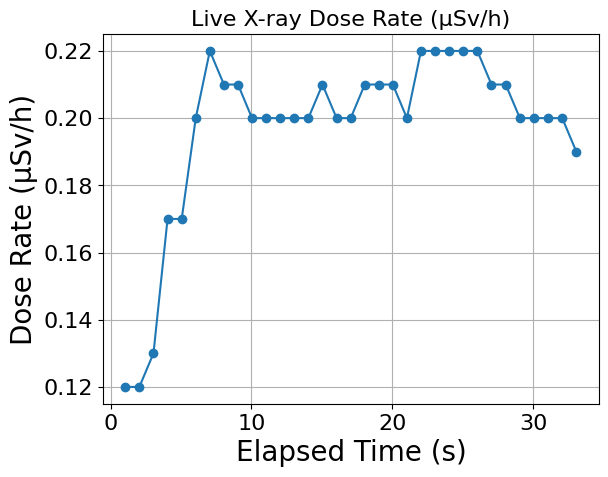

Recording complete. Data saved to record_live_stream_30s_1.hdf


In [83]:
os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test\\4-4-2025_test")

record_live_stream(measure_time=1, record_duration= 30, radeye= radeye)

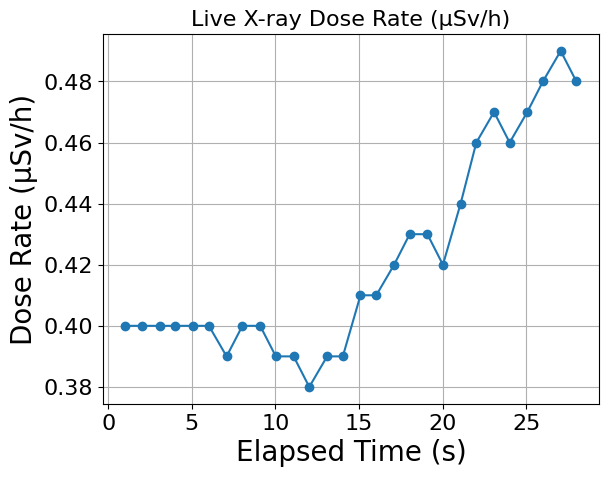

KeyboardInterrupt: 

In [ ]:
os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test\\4-4-2025_test")

ramp_and_record_live_stream(start_v=0,end_v=5.,measure_time = 1,total_ramp_time=60, v_step=0.01, radeye= radeye)